In [1]:
import datetime
import time

import keras

import numpy as np
import pandas as pd
import scipy.signal

%matplotlib inline
import matplotlib.pyplot as plt

import os

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Загрузка данных

In [ ]:
'/Volumes/Untitled/work_folder/work_scripts/ts/2018/dslam/interfaces/10.10.37.28/10.10.37.28.inUtilization.1

In [2]:
root = '/Volumes/Untitled/work_folder/work_scripts/ts/2018/'

In [3]:
rx_bras = pd.read_csv(
    os.path.join(root,'dslam/interfaces/10.10.37.28/10.10.37.28.inUtilization.1'),
    names=['time','value'],
    parse_dates=['time'],
    date_parser=lambda x: datetime.datetime.fromtimestamp(int(x) // 10 ** 6)
)

In [4]:
rx_bras['month'] = rx_bras['time'].dt.month
rx_bras.set_index('time', inplace=True)

### Пример данных

### Подготовка данных к обучению LSTM-нейросети

В качестве обучающего месяца возьмем 9-й, в качестве тестового - 10-й (т.е. апрель и май). Проведем усредняющее ресэмплирование с шагом в 5 минут и заполним отсутствующие значения значениями следующей пятиминутки (метод *bfill*)

In [5]:
train = rx_bras[rx_bras.month == 9]['value'].resample('5T').mean().bfill() 
test  = rx_bras[rx_bras.month == 10]['value'].resample('5T').mean().bfill() 

train = train/train.max()
test  = test/test.max()

In [6]:
ftrain = scipy.signal.medfilt(train, 5)
ftest  = scipy.signal.medfilt(test, 5)

Сформируем обучающий и тестовый тензоры для LSTM-сети.

Нарезаем исходную последовательность на пачки. Смещение каждой пачки = 1. Длина каждой пачки день - 12 \* 5минут \* 24 часа

Также оставляем значения для предсказания. Предсказывать будем следующий час

Количество пачек - длинаВсейПоследовательности - длинаПачки - длинаПредсказания

In [7]:
sequence_length =  12 * 24
prediction_length = 12
ndim = 6
train_matrix   = np.zeros((len(train) - sequence_length - prediction_length, ndim, sequence_length))
y_train_matrix = np.zeros((len(train) - sequence_length - prediction_length, prediction_length))

for index in range(len(train) - sequence_length - prediction_length):
    train_matrix[index, 0, :] = train[index:index+sequence_length]
    train_matrix[index, 1, :] = np.concatenate([[0], np.diff(ftrain[index:index+sequence_length])])
    train_matrix[index, 2, :] = np.cumsum(train[index:index+sequence_length]) / np.sum(train[index:index+sequence_length])
    train_matrix[index, 3, :] = np.maximum.accumulate(train[index:index+sequence_length]) / np.max(train[index:index+sequence_length])
#     train_matrix[index, 4, :] = np.minimum.accumulate(train[index:index+sequence_length]) / np.min(train[index:index+sequence_length])
    train_matrix[index, 4, :] = scipy.signal.medfilt(train[index:index+sequence_length], 7)
    train_matrix[index, 5, :] = scipy.signal.wiener(train[index:index+sequence_length], 13)
    y_train_matrix[index, :]  = ftrain[index+sequence_length:index+sequence_length+prediction_length]

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:950: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:950: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [8]:
test_matrix   = np.zeros((len(test) - sequence_length - prediction_length, ndim, sequence_length))
y_test_matrix = np.zeros((len(test) - sequence_length - prediction_length, prediction_length))

for index in range(len(test) - sequence_length - prediction_length):
    test_matrix[index, 0, :] = test[index:index+sequence_length]
    test_matrix[index, 1, :] = np.concatenate([[0], np.diff(ftest[index:index+sequence_length])])
    test_matrix[index, 2, :] = np.cumsum(test[index:index+sequence_length]) / np.sum(test[index:index+sequence_length])
    test_matrix[index, 3, :] = np.maximum.accumulate(test[index:index+sequence_length]) / np.max(test[index:index+sequence_length])
#     test_matrix[index, 4, :] = np.minimum.accumulate(test[index:index+sequence_length]) / np.min(test[index:index+sequence_length])
    test_matrix[index, 4, :] = scipy.signal.medfilt(test[index:index+sequence_length], 7)
    test_matrix[index, 5, :] = scipy.signal.wiener(test[index:index+sequence_length], 13)
    y_test_matrix[index, :]  = ftest[index+sequence_length:index+sequence_length+prediction_length]

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:950: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:950: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [9]:
print("Размерность обучающего множества: {}".format(train_matrix.shape))
print("Размерность тестового множества:  {}".format(test_matrix.shape))

Размерность обучающего множества: (6724, 6, 288)
Размерность тестового множества:  (8628, 6, 288)


### Нейросетевая модель

In [10]:
batch_size = 48

In [19]:
inp = keras.layers.Input(shape=(ndim, train_matrix.shape[2]))
opt = keras.optimizers.Adam(lr=3*1e-4, decay=1e-6)
#C = keras.layers.Permute(dims=(2, 1))(inp)
#C = keras.layers.convolutional.Conv1D(48, 3, padding='same', kernel_regularizer=keras.regularizers.l2(l=1e-3))(C)
#C = keras.layers.Flatten()(C)

H = keras.layers.LSTM(24, return_sequences=True, kernel_regularizer=keras.regularizers.l2(l=1e-4))(inp)
#H = keras.layers.concatenate(inputs=[H, inp])

H = keras.layers.Dropout(0.4)(H)
H1 = keras.layers.LSTM(8, return_sequences=False, go_backwards=True, kernel_regularizer=keras.regularizers.l2(l=1e-4))(H)
H2 = keras.layers.LSTM(8, return_sequences=False, kernel_regularizer=keras.regularizers.l2(l=1e-4))(H)

H = keras.layers.concatenate(inputs=[H1, H2]) #, C])
H = keras.layers.Dropout(0.4)(H)

# H = keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(l=1e-4))(H)
# H = keras.layers.Dropout(0.4)(H)

H = keras.layers.Dense(prediction_length, activation='linear', kernel_regularizer=keras.regularizers.l2(l=1e-4))(H)

model = keras.models.Model(inputs=inp, outputs=H)
model.compile(loss='mae', optimizer=opt)

In [20]:
%%time
hist = model.fit(x=train_matrix, y=y_train_matrix, validation_split=0.2, 
                 batch_size=batch_size, epochs=200, shuffle=False)

Train on 5379 samples, validate on 1345 samples
Epoch 1/200
5379/5379 [==============================] - 8s 1ms/step - loss: 0.1354 - val_loss: 0.1010
Epoch 2/200
5379/5379 [==============================] - 3s 544us/step - loss: 0.1133 - val_loss: 0.0961
Epoch 3/200
5379/5379 [==============================] - 3s 545us/step - loss: 0.1025 - val_loss: 0.0921
Epoch 4/200
5379/5379 [==============================] - 3s 531us/step - loss: 0.0966 - val_loss: 0.0889
Epoch 5/200
5379/5379 [==============================] - 3s 535us/step - loss: 0.0908 - val_loss: 0.0856
Epoch 6/200
5379/5379 [==============================] - 3s 538us/step - loss: 0.0870 - val_loss: 0.0833
Epoch 7/200
5379/5379 [==============================] - 3s 531us/step - loss: 0.0831 - val_loss: 0.0809
Epoch 8/200
5379/5379 [==============================] - 3s 529us/step - loss: 0.0809 - val_loss: 0.0791
Epoch 9/200
5379/5379 [==============================] - 3s 533us/step - loss: 0.0785 - val_loss: 0.0770
Epoch 10/

5379/5379 [==============================] - 4s 813us/step - loss: 0.0477 - val_loss: 0.0527
Epoch 78/200
5379/5379 [==============================] - 4s 747us/step - loss: 0.0484 - val_loss: 0.0516
Epoch 79/200
5379/5379 [==============================] - 4s 780us/step - loss: 0.0476 - val_loss: 0.0519
Epoch 80/200
5379/5379 [==============================] - 4s 671us/step - loss: 0.0472 - val_loss: 0.0518
Epoch 81/200
5379/5379 [==============================] - 3s 637us/step - loss: 0.0479 - val_loss: 0.0515
Epoch 82/200
5379/5379 [==============================] - 3s 578us/step - loss: 0.0472 - val_loss: 0.0515
Epoch 83/200
5379/5379 [==============================] - 3s 620us/step - loss: 0.0479 - val_loss: 0.0529
Epoch 84/200
5379/5379 [==============================] - 4s 656us/step - loss: 0.0476 - val_loss: 0.0513
Epoch 85/200
5379/5379 [==============================] - 3s 496us/step - loss: 0.0469 - val_loss: 0.0512
Epoch 86/200
5379/5379 [==============================] - 3

Epoch 154/200
5379/5379 [==============================] - 3s 475us/step - loss: 0.0442 - val_loss: 0.0527
Epoch 155/200
5379/5379 [==============================] - 3s 474us/step - loss: 0.0443 - val_loss: 0.0525
Epoch 156/200
5379/5379 [==============================] - 3s 485us/step - loss: 0.0445 - val_loss: 0.0523
Epoch 157/200
5379/5379 [==============================] - 3s 476us/step - loss: 0.0437 - val_loss: 0.0486
Epoch 158/200
5379/5379 [==============================] - 3s 484us/step - loss: 0.0439 - val_loss: 0.0534
Epoch 159/200
5379/5379 [==============================] - 3s 479us/step - loss: 0.0443 - val_loss: 0.0528
Epoch 160/200
5379/5379 [==============================] - 3s 484us/step - loss: 0.0442 - val_loss: 0.0522
Epoch 161/200
5379/5379 [==============================] - 3s 480us/step - loss: 0.0438 - val_loss: 0.0523
Epoch 162/200
5379/5379 [==============================] - 3s 480us/step - loss: 0.0442 - val_loss: 0.0524
Epoch 163/200
5379/5379 [============

### Прогноз

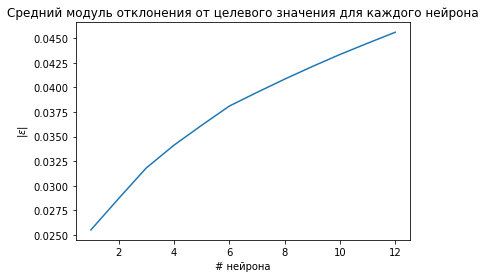

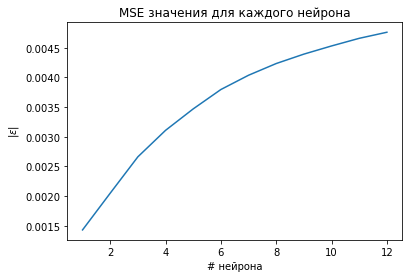

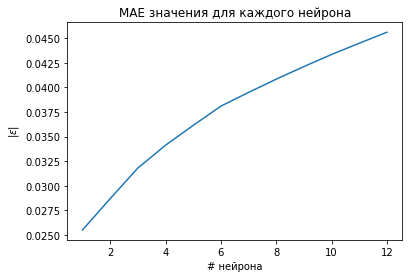

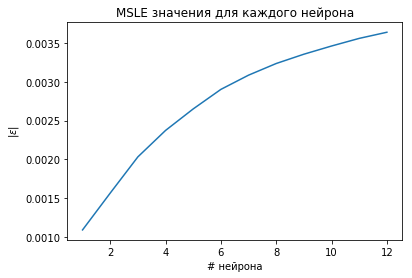

In [13]:
fig = plt.figure()
err = np.sum(np.abs(y_test_matrix - model.predict(x=test_matrix, batch_size=batch_size)) / y_test_matrix.shape[0], axis=0)
plt.plot(range(1, prediction_length+1), err)
plt.xlabel('# нейрона')
plt.ylabel('$|\epsilon|$')
plt.title('Средний модуль отклонения от целевого значения для каждого нейрона')

fig = plt.figure()
err = mean_squared_error(y_test_matrix, model.predict(x=test_matrix, batch_size=batch_size), multioutput='raw_values')
plt.plot(range(1, prediction_length+1), err)
plt.xlabel('# нейрона')
plt.ylabel('$|\epsilon|$')
plt.title('MSE значения для каждого нейрона')

fig = plt.figure()
err = mean_absolute_error(y_test_matrix, model.predict(x=test_matrix, batch_size=batch_size), multioutput='raw_values')
plt.plot(range(1, prediction_length+1), err)
plt.xlabel('# нейрона')
plt.ylabel('$|\epsilon|$')
plt.title('MAE значения для каждого нейрона')

fig = plt.figure()
err = mean_squared_log_error(y_test_matrix, model.predict(x=test_matrix, batch_size=batch_size), multioutput='raw_values')
plt.plot(range(1, prediction_length+1), err)
plt.xlabel('# нейрона')
plt.ylabel('$|\epsilon|$')
plt.title('MSLE значения для каждого нейрона')

In [14]:
prediction = model.predict(x=test_matrix, batch_size=batch_size)

In [15]:
prediction.shape

(8628, 12)

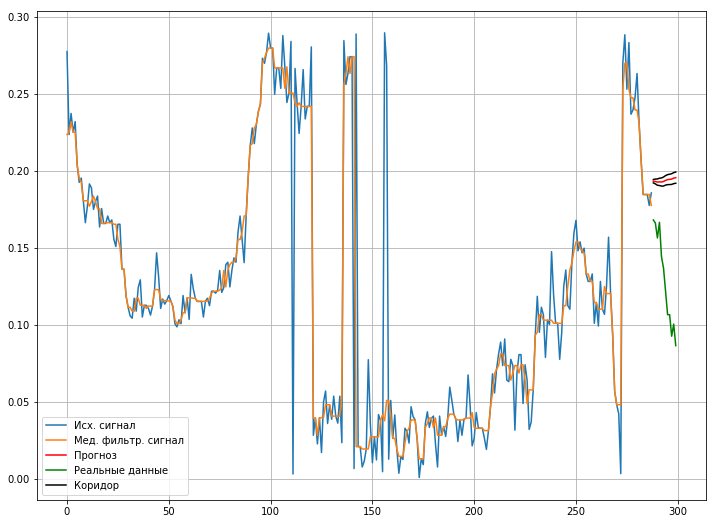

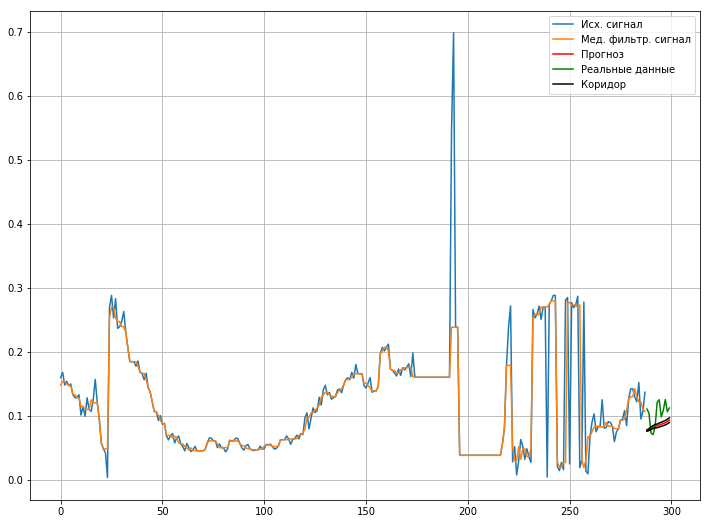

In [18]:
fig = plt.figure(figsize=(12, 9))
pos = 1
plt.plot(range(0, test_matrix[pos, 0, :].shape[0]), test_matrix[pos, 0, :], label='Исх. сигнал')
plt.plot(range(0, test_matrix[pos, 0, :].shape[0]), ftest[pos:pos+sequence_length], label='Мед. фильтр. сигнал')

plt.plot(range(test_matrix[pos, 0, :].shape[0], test_matrix[pos, 0, :].shape[0] + prediction_length), 
         prediction[pos], 'r', label='Прогноз')
plt.plot(range(test_matrix[pos, 0, :].shape[0], test_matrix[pos, 0, :].shape[0] + prediction_length), 
         test_matrix[pos+sequence_length, 0, :prediction_length], 'g', label='Реальные данные')
plt.plot(range(test_matrix[pos, 0, :].shape[0], test_matrix[pos, 0, :].shape[0] + prediction_length), 
         prediction[pos] + err, 'k', label='Коридор')
plt.plot(range(test_matrix[pos, 0, :].shape[0], test_matrix[pos, 0, :].shape[0] + prediction_length), 
         prediction[pos] - err, 'k')
plt.grid(True)
plt.legend()

fig = plt.figure(figsize=(12, 9))
pos = 250
plt.plot(range(0, test_matrix[pos, 0, :].shape[0]), test_matrix[pos, 0, :], label='Исх. сигнал')
plt.plot(range(0, test_matrix[pos, 0, :].shape[0]), ftest[pos:pos+sequence_length], label='Мед. фильтр. сигнал')

plt.plot(range(test_matrix[pos, 0, :].shape[0], test_matrix[pos, 0, :].shape[0] + prediction_length), 
         prediction[pos], 'r', label='Прогноз')
plt.plot(range(test_matrix[pos, 0, :].shape[0], test_matrix[pos, 0, :].shape[0] + prediction_length), 
         test_matrix[pos+sequence_length, 0, :prediction_length], 'g', label='Реальные данные')
plt.plot(range(test_matrix[pos, 0, :].shape[0], test_matrix[pos, 0, :].shape[0] + prediction_length), 
         prediction[pos] + err, 'k', label='Коридор')
plt.plot(range(test_matrix[pos, 0, :].shape[0], test_matrix[pos, 0, :].shape[0] + prediction_length), 
         prediction[pos] - err, 'k')
plt.grid(True)
plt.legend()

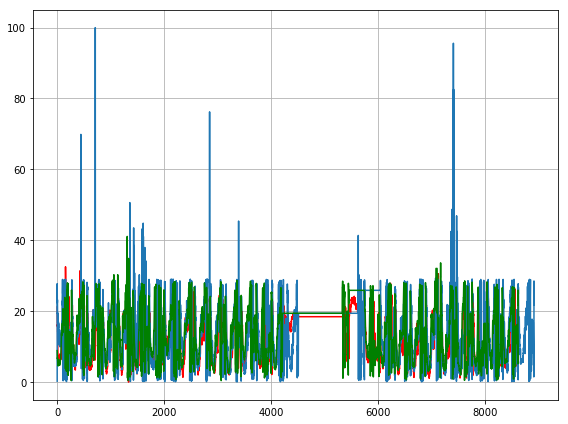

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, prediction.shape[0]), prediction[:, 0] * 100, 'r')
test.mul(100).reset_index(drop=True).plot()
plt.plot(np.arange(0, prediction.shape[0]), ftest[sequence_length+prediction_length:] * 100, 'g')
plt.grid()
plt.tight_layout()